<a href="https://colab.research.google.com/github/eric-pierce/MSDS-422-HW/blob/master/epierce_assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8: Language Modeling With an RNN
## MSDS-422 Spring 2019 - Eric Pierce
## Background  
Management is interested in using sentiment analysis to understand the most critical customer complaints from collected reviews and call logs so that customer support can be assigned to those cases. The GloVe 50d pretrained embeddings <glove.6B.50d.txt> are being leveraged alongside a dataset containing 500 positive and 500 negative movie reviews in order to understand the sentiment of these customer complaints. GloVe 50d consists of 400,000 words with 50 vectors each.
## Objective
Management is evaluating machine learning technologies to improve customer relationship management. This is focused on neural network typology and hyperparameter settings with Recurrant Neural Networks to determine accuracy.

# Setup and Data Import
Initialize the data and libraries used as part of this project

### Library Import and Setting Initialization

In [88]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import keras

import tensorflow as tf
import os
import os.path
import re
import nltk
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from nltk.tokenize import TreebankWordTokenizer
from collections import defaultdict
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Import

In [0]:
g6b50d = pd.read_csv("/content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings/glove.6B.50d.txt", sep="\s", engine="python", names=np.arange(1,51))
g6b50d.index.name = "word"

# Exploratory Data Analysis
*   Clean Data
*   Identify Data Descriptions and Statistics
*   Visualize Input Data

### Clean Data

Examine the shape of original input data

In [0]:
print(g6b50d.shape)

(400000, 50)


After dropping any non-populated values the shape is the same, therefore all values are populated

In [0]:
g6b50d.dropna()
print(g6b50d.shape)

(400000, 50)


Sample rows, each row consists of a label identifying the actual number written, followed by 783 pixels (28x28 image)

In [0]:
g6b50d.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
word,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,0.278430,-0.147670,-0.55677,0.14658,-0.00951,0.011658,0.102040,-0.127920,-0.84430,-0.121810,-0.016801,-0.332790,-0.155200,-0.231310,-0.191810,-1.8823,-0.76746,0.099051,-0.421250,-0.19526,4.0071,-0.185940,-0.522870,-0.31681,0.000592,0.007445,0.17778,-0.158970,0.012041,-0.054223,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,0.130010,-0.063734,-0.39575,-0.48162,0.23291,0.090201,-0.133240,0.078639,-0.41634,-0.154280,0.100680,0.488910,0.312260,-0.125200,-0.037512,-1.5179,0.12612,-0.024420,-0.042961,-0.28351,3.5416,-0.119560,-0.014533,-0.14990,0.218640,-0.334120,-0.13872,0.318060,0.703580,0.448580,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,0.166080,0.119630,-0.41328,-0.42353,0.59868,0.288250,-0.115470,-0.041848,-0.67989,-0.250630,0.184720,0.086876,0.465820,0.015035,0.043474,-1.4671,-0.30384,-0.023441,0.305890,-0.21785,3.7460,0.004228,-0.184360,-0.46209,0.098329,-0.119070,0.23919,0.116100,0.417050,0.056763,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,0.078852,-0.362160,-0.11829,-0.83336,0.11917,-0.166050,0.061555,-0.012719,-0.56623,0.013616,0.228510,-0.143960,-0.067549,-0.381570,-0.236980,-1.7037,-0.86692,-0.267040,-0.258900,0.17670,3.8676,-0.161300,-0.132730,-0.68881,0.184440,0.005246,-0.33874,-0.078956,0.241850,0.365760,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,0.171180,0.224190,-0.10046,-0.43653,0.33418,0.678460,0.057204,-0.344480,-0.42785,-0.432750,0.559630,0.100320,0.186770,-0.268540,0.037334,-2.0932,0.22171,-0.398680,0.209120,-0.55725,3.8826,0.474660,-0.956580,-0.37788,0.208690,-0.327520,0.12751,0.088359,0.163510,-0.216340,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


### Visualize Input Data

#### Numeric Parameter Histograms

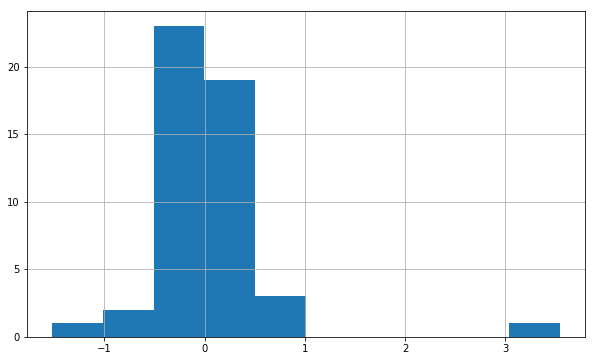

In [0]:
g6b50d.iloc[:, 1:].iloc[1].hist(figsize=(10,6))
plt.show()

# Initial Tensorflow Model Training with JumpStart

Set Parameters

In [0]:
EVOCABSIZE = 10000  # specify desired size of pre-defined embedding vocabulary 

Define helper Functions

In [0]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array([float(val) for val in representation])

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding

def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z\r\n\t]', '  ', string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)    

def read_data(filename):
  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank
  return data

# To make output stable across runs
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Load and Process Embeddings. We return a tuple of two dictionaries (word_to_index_dict, index_to_embedding_array), otherwise we return only a direct word_to_embedding_dict dictionary mapping from a string to a numpy array.

In [155]:
embeddings_directory = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings'
filename = 'glove.6B.50d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)
      
print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings/glove.6B.50d.txt
Embedding loaded from disks.


Read in Movie Review Data. Data will be stored in a list of lists where the each list represents, a document and document is a list of words. We then break the text into words.

In [135]:
# -----------------------------------------------
# gather data for 500 negative movie reviews
# -----------------------------------------------

dir_name = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/movie-reviews-negative'
    
filenames = [i for i in os.listdir(dir_name)]
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('%d negative reviews found' % len(filenames))

negative_documents = []

for i in range(num_files):
    words = read_data(os.path.join(dir_name, filenames[i]))
    negative_documents.append(words)
print('negative reviews loaded')

# -----------------------------------------------
# gather data for 500 positive movie reviews
# -----------------------------------------------

dir_name = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/movie-reviews-positive'
filenames = [i for i in os.listdir(dir_name)]
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\n%d positive reviews found' % len(filenames))

positive_documents = []

for i in range(num_files):
    words = read_data(os.path.join(dir_name, filenames[i]))
    positive_documents.append(words)
print('positive reviews loaded')

max_review_length = 0
min_review_length = 9999999
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))
    min_review_length = min(min_review_length, len(doc))
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc))
    min_review_length = min(min_review_length, len(doc))
print('\nmax_review_length:', max_review_length)
print('min_review_length:', min_review_length)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), np.ones((500), dtype = np.int32)), axis = 0)

500 negative reviews found
negative reviews loaded

500 positive reviews found
positive reviews loaded

max_review_length: 1052
min_review_length: 22


Format embeddings for use in an RNN

In [0]:
limited_word_to_index = defaultdict(default_factory, {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
limited_index_to_embedding = np.append(limited_index_to_embedding, index_to_embedding[index_to_embedding.shape[0] - 1, :].reshape(1,index_to_embedding.shape[1]), axis = 0)

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

embeddings_array = np.array(embeddings)

Define test/train datasets for validation in RNN

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, random_state = RANDOM_SEED)
reset_graph()

### Model Definition and Training

Run an initial RNN using the Jumpstart RNN TF Raw code

In [158]:
n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

model_results={}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('Epoch',epoch,'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        model_results[epoch]= {'Train_Acc':acc_train, 'Test_Acc':acc_test}

Epoch 0 Train accuracy: 0.57 Test accuracy: 0.465
Epoch 1 Train accuracy: 0.58 Test accuracy: 0.46
Epoch 2 Train accuracy: 0.61 Test accuracy: 0.47
Epoch 3 Train accuracy: 0.59 Test accuracy: 0.46
Epoch 4 Train accuracy: 0.65 Test accuracy: 0.44
Epoch 5 Train accuracy: 0.62 Test accuracy: 0.46
Epoch 6 Train accuracy: 0.62 Test accuracy: 0.47
Epoch 7 Train accuracy: 0.59 Test accuracy: 0.465
Epoch 8 Train accuracy: 0.58 Test accuracy: 0.47
Epoch 9 Train accuracy: 0.59 Test accuracy: 0.485
Epoch 10 Train accuracy: 0.61 Test accuracy: 0.48
Epoch 11 Train accuracy: 0.61 Test accuracy: 0.48
Epoch 12 Train accuracy: 0.65 Test accuracy: 0.485
Epoch 13 Train accuracy: 0.64 Test accuracy: 0.5
Epoch 14 Train accuracy: 0.66 Test accuracy: 0.485
Epoch 15 Train accuracy: 0.65 Test accuracy: 0.485
Epoch 16 Train accuracy: 0.66 Test accuracy: 0.48
Epoch 17 Train accuracy: 0.67 Test accuracy: 0.495
Epoch 18 Train accuracy: 0.68 Test accuracy: 0.5
Epoch 19 Train accuracy: 0.66 Test accuracy: 0.5
Epoch 

### Model Results

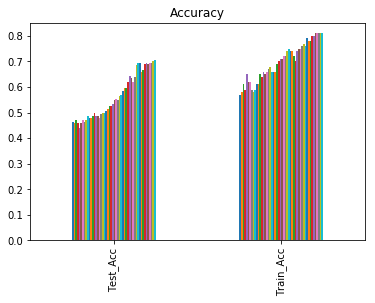

In [159]:
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_df.plot(kind='bar', legend=False)
plt.title('Accuracy')

plt.show()

In [161]:
results_df = pd.DataFrame({'TestName': '50d Dataset Tensorflow',
   'VocabluarySize': [EVOCABSIZE],
   'Dimensions': [n_epochs],
   'Neurons': [n_neurons],
   'LearningRate': [learning_rate],
   'TrainingSetAccuracy': [acc_train],
   'TestSetAccuracy': [acc_test]})
results_df.set_index('TestName', inplace=True)
results_df

,VocabluarySize,Dimensions,Neurons,LearningRate,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,,
50d Dataset Tensorflow,10000,50,20,0.001,0.81,0.705


# Second Tensorflow Model Training with Jumpstart and 100d Dataset

Update Vocab size to be larger

In [0]:
EVOCABSIZE = 400000  # specify desired size of pre-defined embedding vocabulary 

### Setup processing for 100d Dataset

Load 100d embedding

In [163]:
embeddings_directory = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings'
filename = 'glove.6B.100d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings/glove.6B.100d.txt
Embedding loaded from disks.


Process embedding

In [164]:
limited_word_to_index = defaultdict(default_factory, {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
limited_index_to_embedding = np.append(limited_index_to_embedding, index_to_embedding[index_to_embedding.shape[0] - 1, :].reshape(1,index_to_embedding.shape[1]), axis = 0)

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

embeddings_array = np.array(embeddings)
embeddings_array.shape

(1000, 40, 100)

Define test/train datasets for validation in RNN

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, random_state = RANDOM_SEED)
reset_graph()

### Model Definition and Training

In [166]:
n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 150
batch_size = 100

model_results={}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('Epoch',epoch,'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        model_results[epoch]= {'Train_Acc':acc_train, 'Test_Acc':acc_test}

Epoch 0 Train accuracy: 0.53 Test accuracy: 0.485
Epoch 1 Train accuracy: 0.53 Test accuracy: 0.48
Epoch 2 Train accuracy: 0.59 Test accuracy: 0.45
Epoch 3 Train accuracy: 0.58 Test accuracy: 0.545
Epoch 4 Train accuracy: 0.62 Test accuracy: 0.53
Epoch 5 Train accuracy: 0.67 Test accuracy: 0.495
Epoch 6 Train accuracy: 0.67 Test accuracy: 0.485
Epoch 7 Train accuracy: 0.7 Test accuracy: 0.485
Epoch 8 Train accuracy: 0.69 Test accuracy: 0.485
Epoch 9 Train accuracy: 0.7 Test accuracy: 0.5
Epoch 10 Train accuracy: 0.71 Test accuracy: 0.505
Epoch 11 Train accuracy: 0.72 Test accuracy: 0.54
Epoch 12 Train accuracy: 0.75 Test accuracy: 0.545
Epoch 13 Train accuracy: 0.76 Test accuracy: 0.54
Epoch 14 Train accuracy: 0.78 Test accuracy: 0.545
Epoch 15 Train accuracy: 0.78 Test accuracy: 0.56
Epoch 16 Train accuracy: 0.78 Test accuracy: 0.565
Epoch 17 Train accuracy: 0.78 Test accuracy: 0.585
Epoch 18 Train accuracy: 0.78 Test accuracy: 0.59
Epoch 19 Train accuracy: 0.8 Test accuracy: 0.59
Epo

### Model Results

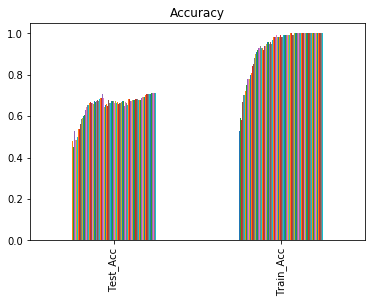

In [167]:
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_df.plot(kind='bar', legend=False)
plt.title('Accuracy')

plt.show()

In [168]:
results_df2=(pd.DataFrame({'TestName': '100d Dataset Tensorflow',
   'VocabluarySize': [EVOCABSIZE],
   'Dimensions': [n_epochs],
   'Neurons': [n_neurons],
   'LearningRate': [learning_rate],
   'TrainingSetAccuracy': [acc_train],
   'TestSetAccuracy': [acc_test]}))
results_df2.set_index('TestName', inplace=True)
results_df2

,VocabluarySize,Dimensions,Neurons,LearningRate,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,,
100d Dataset Tensorflow,400000,150,20,0.001,1.0,0.71


# Third Tensorflow Model Training with Jumpstart and 100d Dataset

Update Vocab size to be larger

In [0]:
EVOCABSIZE = 400000  # specify desired size of pre-defined embedding vocabulary 

### Setup processing for 100d Dataset

Load 100d embedding

In [107]:
embeddings_directory = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings'
filename = 'glove.6B.100d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings/glove.6B.100d.txt
Embedding loaded from disks.


Process embedding

In [170]:
limited_word_to_index = defaultdict(default_factory, {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
limited_index_to_embedding = np.append(limited_index_to_embedding, index_to_embedding[index_to_embedding.shape[0] - 1, :].reshape(1,index_to_embedding.shape[1]), axis = 0)

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

embeddings_array = np.array(embeddings)
embeddings_array.shape

(1000, 40, 100)

Define test/train datasets for validation in RNN

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, random_state = RANDOM_SEED)
reset_graph()

### Model Definition and Training

In [172]:
n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 40  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.01

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 150
batch_size = 100

model_results={}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('Epoch',epoch,'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        model_results[epoch]= {'Train_Acc':acc_train, 'Test_Acc':acc_test}

Epoch 0 Train accuracy: 0.67 Test accuracy: 0.54
Epoch 1 Train accuracy: 0.75 Test accuracy: 0.55
Epoch 2 Train accuracy: 0.76 Test accuracy: 0.59
Epoch 3 Train accuracy: 0.85 Test accuracy: 0.57
Epoch 4 Train accuracy: 0.86 Test accuracy: 0.615
Epoch 5 Train accuracy: 0.94 Test accuracy: 0.585
Epoch 6 Train accuracy: 0.97 Test accuracy: 0.6
Epoch 7 Train accuracy: 0.98 Test accuracy: 0.585
Epoch 8 Train accuracy: 0.96 Test accuracy: 0.51
Epoch 9 Train accuracy: 0.85 Test accuracy: 0.48
Epoch 10 Train accuracy: 0.94 Test accuracy: 0.52
Epoch 11 Train accuracy: 0.94 Test accuracy: 0.51
Epoch 12 Train accuracy: 0.98 Test accuracy: 0.52
Epoch 13 Train accuracy: 1.0 Test accuracy: 0.52
Epoch 14 Train accuracy: 1.0 Test accuracy: 0.475
Epoch 15 Train accuracy: 1.0 Test accuracy: 0.48
Epoch 16 Train accuracy: 1.0 Test accuracy: 0.49
Epoch 17 Train accuracy: 1.0 Test accuracy: 0.485
Epoch 18 Train accuracy: 1.0 Test accuracy: 0.48
Epoch 19 Train accuracy: 1.0 Test accuracy: 0.475
Epoch 20 Tra

### Model Results

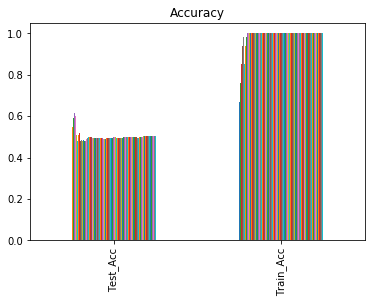

In [173]:
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_df.plot(kind='bar', legend=False)
plt.title('Accuracy')

plt.show()

In [174]:
results_df3=(pd.DataFrame({'TestName': '100d Dataset Tensorflow 40 neurons',
   'VocabluarySize': [EVOCABSIZE],
   'Dimensions': [n_epochs],
   'Neurons': [n_neurons],
   'LearningRate': [learning_rate],
   'TrainingSetAccuracy': [acc_train],
   'TestSetAccuracy': [acc_test]}))
results_df3.set_index('TestName', inplace=True)
results_df3

,VocabluarySize,Dimensions,Neurons,LearningRate,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,,
100d Dataset Tensorflow 40 neurons,400000,150,40,0.01,1.0,0.505


# Forth Tensorflow Model Training with Jumpstart and 100d Dataset

Update Vocab size to be larger

In [0]:
EVOCABSIZE = 400000  # specify desired size of pre-defined embedding vocabulary 

### Setup processing for 100d Dataset

Load 100d embedding

In [0]:
embeddings_directory = '/content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings'
filename = 'glove.6B.100d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /content/gdrive/My Drive/MSDS-422-Gift/module_8/embeddings/glove.6B.100d.txt
Embedding loaded from disks.


Process embedding

In [175]:
limited_word_to_index = defaultdict(default_factory, {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
limited_index_to_embedding = np.append(limited_index_to_embedding, index_to_embedding[index_to_embedding.shape[0] - 1, :].reshape(1,index_to_embedding.shape[1]), axis = 0)

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

embeddings_array = np.array(embeddings)
embeddings_array.shape

(1000, 40, 100)

Define test/train datasets for validation in RNN

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, random_state = RANDOM_SEED)
reset_graph()

### Model Definition and Training

In [177]:
n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.0001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 150
batch_size = 100

model_results={}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('Epoch',epoch,'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        model_results[epoch]= {'Train_Acc':acc_train, 'Test_Acc':acc_test}

Epoch 0 Train accuracy: 0.47 Test accuracy: 0.515
Epoch 1 Train accuracy: 0.48 Test accuracy: 0.52
Epoch 2 Train accuracy: 0.45 Test accuracy: 0.525
Epoch 3 Train accuracy: 0.45 Test accuracy: 0.505
Epoch 4 Train accuracy: 0.47 Test accuracy: 0.505
Epoch 5 Train accuracy: 0.48 Test accuracy: 0.505
Epoch 6 Train accuracy: 0.45 Test accuracy: 0.485
Epoch 7 Train accuracy: 0.49 Test accuracy: 0.48
Epoch 8 Train accuracy: 0.49 Test accuracy: 0.49
Epoch 9 Train accuracy: 0.51 Test accuracy: 0.505
Epoch 10 Train accuracy: 0.53 Test accuracy: 0.5
Epoch 11 Train accuracy: 0.53 Test accuracy: 0.49
Epoch 12 Train accuracy: 0.55 Test accuracy: 0.495
Epoch 13 Train accuracy: 0.55 Test accuracy: 0.49
Epoch 14 Train accuracy: 0.54 Test accuracy: 0.505
Epoch 15 Train accuracy: 0.54 Test accuracy: 0.515
Epoch 16 Train accuracy: 0.55 Test accuracy: 0.515
Epoch 17 Train accuracy: 0.56 Test accuracy: 0.515
Epoch 18 Train accuracy: 0.56 Test accuracy: 0.515
Epoch 19 Train accuracy: 0.55 Test accuracy: 0.5

### Model Results

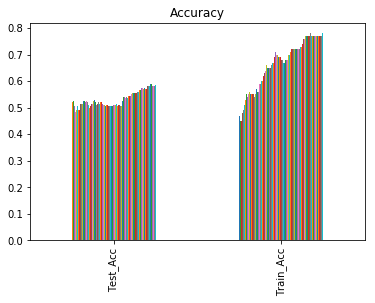

In [178]:
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_df.plot(kind='bar', legend=False)
plt.title('Accuracy')

plt.show()

In [179]:
results_df4=(pd.DataFrame({'TestName': '100d Dataset Tensorflow lower learning',
   'VocabluarySize': [EVOCABSIZE],
   'Dimensions': [n_epochs],
   'Neurons': [n_neurons],
   'LearningRate': [learning_rate],
   'TrainingSetAccuracy': [acc_train],
   'TestSetAccuracy': [acc_test]}))
results_df4.set_index('TestName', inplace=True)
results_df4

,VocabluarySize,Dimensions,Neurons,LearningRate,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,,
100d Dataset Tensorflow lower learning,400000,150,20,0.0001,0.78,0.585


# Results

In [180]:
results_df_compiled = pd.concat([results_df,results_df2,results_df3,results_df4], ignore_index=False)
results_df_compiled

,VocabluarySize,Dimensions,Neurons,LearningRate,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,,
50d Dataset Tensorflow,10000,50,20,0.0010,0.81,0.705
100d Dataset Tensorflow,400000,150,20,0.0010,1.00,0.710
100d Dataset Tensorflow 40 neurons,400000,150,40,0.0100,1.00,0.505
100d Dataset Tensorflow lower learning,400000,150,20,0.0001,0.78,0.585


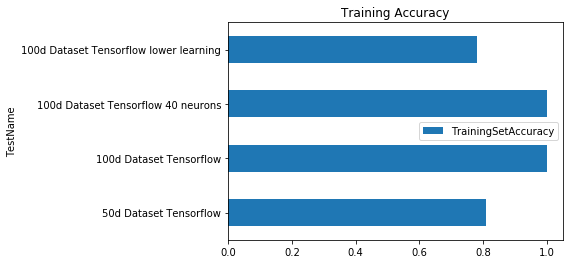

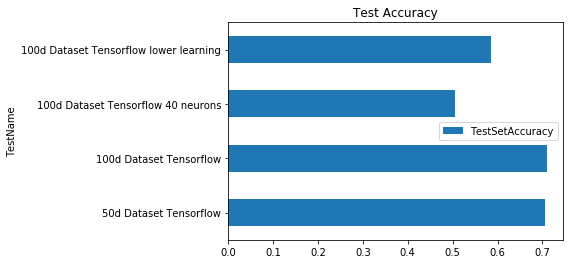

In [181]:
results_df_compiled[['TrainingSetAccuracy']].plot(kind='barh', title='Training Accuracy')
results_df_compiled[['TestSetAccuracy']].plot(kind='barh', title='Test Accuracy')
plt.show()

# Recommendations

Leveraging the full vocabulary dataset with the 100d model parameters produced the most accurate model. Of the rates tested, the learning rate performs best at 0.001 and the neuron count is best set at 20. This RNN appears to be sensitive to overfitting, as the training accuracy is very high and the test accuracy relatively low.